# PyTorch Tutorial: Matrix Multiplications, Non-linear Activations, and Network Shape




#### Author: Antonio Rueda-Toicen

**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).


This notebook explores foundational concepts in neural networks using PyTorch.

We'll focus on:

1.  **Matrix Multiplication:** How it forms the core computation within network layers.
2.  **Network Shape:** How the dimensions of matrices (tensors in PyTorch) define the architecture of a neural network (number of input features, output features, and connections).
3.  **Non-linear Activations:** Why linear operations (like matrix multiplication) alone are not enough, and how functions like [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) enable networks to learn complex patterns.

By the end of this tutorial, you should:

*   Understand the relationship between matrix multiplication dimensions and a network's architecture (its shape).
*   Recognize the importance of passing the output of matrix multiplication operations through non-linear activation functions.
*   Be comfortable implementing these concepts using both direct `torch.matmul` and the `torch.nn.Linear` layer in PyTorch.
*   Be aware of common errors related to tensor dimensions (that we can check using `tensor_name.shape`)

Let's get started!




## Imports

In [25]:
# First, let's import the  PyTorch library.

import torch
import torch.nn as nn
# We'll use Parameter to show trainable weights
from torch.nn.parameter import Parameter

print(f"PyTorch version: {torch.__version__}")



PyTorch version: 2.6.0+cu124


## 1. The Feedforward Pass and Network Shape (Output Layer Example)


The feedforward pass describes how information flows through a neural network. It goes from an input layer, through hidden layers (if any), to an output layer. [Matrix multiplication](https://matrixmultiplication.xyz/) is the operation that combines inputs and weights at each layer.

Consider a simple case where we map 4 input features (e.g., from a hidden layer or the raw input) to a single output value.

*   Input **X** has shape `(batch_size, input_features)`
*   Weights **W** have shape `(input_features, output_features)`
*   Output **Z = XW** has shape `(batch_size, output_features)`

In our example: `input_features = 4`, `output_features = 1`.



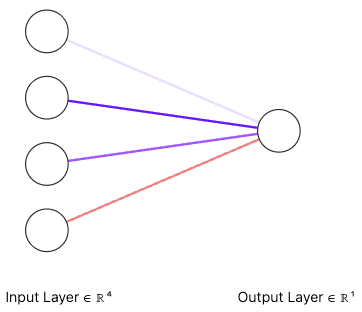

*Image from https://alexlenail.me/NN-SVG/index.html*

Let's implement this in PyTorch. We'll use a `batch_size` of 1 for simplicity, meaning we process one input sample at a time.



In [26]:
# Define network dimensions
batch_size = 1
input_features = 4  # Like X1, X2, X3, X4
output_features = 1 # Like Z (a single scalar output)

# Create a random input tensor X
# Shape: (batch_size, input_features) -> (1, 4)
X = torch.randn(batch_size, input_features)
print(f"Input X (shape {X.shape}):")
print(X)
print("-" * 20)

# Create a random weight tensor W
# Shape: (input_features, output_features) -> (4, 1)
weights = torch.randn(input_features, output_features)
print(f"Weights W (shape {weights.shape}):")
# .squeeze() removes dimensions of size 1 for cleaner printing
print(weights.squeeze())
print("-" * 20)



Input X (shape torch.Size([1, 4])):
tensor([[-0.2536, -0.3532, -0.0834, -0.1053]])
--------------------
Weights W (shape torch.Size([4, 1])):
tensor([ 0.9454, -0.5094,  0.0475,  1.6230])
--------------------


### Approach 1: Direct Matrix Multiplication

This is the least common way that we will design a neural network, but it's important to know how we do this in PyTorch.


In [27]:
# Syntax option 1 for matrix multiplication: X @ weights
Z = X @ weights #(equivalent to torch.matmul(X, W))
print(f"Output using X @ weights (shape {Z.shape}):")
Z.item() # We use .item() to access the content of the tensor, discarding its shape

Output using X @ weights (shape torch.Size([1, 1])):


-0.23479336500167847

In [28]:
# Real tensor output without .item()
Z

tensor([[-0.2348]])

In [29]:
# Shape check: (1, 4) @ (4, 1) -> (1, 1)
X.shape, weights.shape, Z.shape

(torch.Size([1, 4]), torch.Size([4, 1]), torch.Size([1, 1]))

In [30]:
output_matmul = torch.matmul(X, weights)
print(f"Output using torch.matmul (shape {output_matmul.shape}):")
# .item() extracts the single scalar value from a tensor with one element
print(f"{output_matmul.item():.4f}") # We use a format string to reduce digits


Output using torch.matmul (shape torch.Size([1, 1])):
-0.2348


###  Approach 2: Using `nn.Linear`

`nn.Linear` layers wrap the computation of weights times features to produce an output.

In [31]:
# nn.Linear encapsulates the matrix multiplication (XW^T + b)
# We set bias=False to exactly replicate Z = XW
layer = nn.Linear(in_features=input_features,
                  out_features=output_features,
                  bias=False)

# Note: nn.Linear layers have their own internal weights.
# To compare apples-to-apples with the matmul approach, we need to
# manually set the layer's weight to our 'weights' tensor.
# nn.Linear expects weights of shape (out_features, in_features)
# so we need to transpose our 'weights' tensor.
with torch.no_grad(): # Temporarily disable gradient tracking for manual assignment
    layer.weight.copy_(weights.T) # Transpose W to match nn.Linear's expectation

output_linear = layer(X)
print(f"Output using nn.Linear (shape {output_linear.shape}):")
print(f"{output_linear.item():.4f}")
print("-" * 20)

# Verify internal weights of the nn.Linear layer (should match our 'weights' after transpose)
print(f"nn.Linear layer's weight tensor (shape {layer.weight.shape}):")
# We transpose it back here for easier comparison with our original 'weights'
print(layer.weight.T.squeeze())



Output using nn.Linear (shape torch.Size([1, 1])):
-0.2348
--------------------
nn.Linear layer's weight tensor (shape torch.Size([1, 4])):
tensor([ 0.9454, -0.5094,  0.0475,  1.6230], grad_fn=<SqueezeBackward0>)



#### Key Points:
*   The shapes `(1, 4)` for input and `(4, 1)` for weights determine the structure: 4 input units connecting to 1 output unit.
*   `torch.matmul` performs the raw mathematical operation.
*   `nn.Linear` is PyTorch's building block for layers, handling weights (and biases, by default) automatically. It's more convenient for building larger networks.
*   Note the difference in expected weight shape between manual `matmul` (input, output) and `nn.Linear` (output, input).




## 2. Common Errors with Tensor Dimensions


**Getting tensor shapes right is important** and missing this is often a source of bugs. Let's look at common mistakes using variations of the previous code.

 **(Note: The following cells are expected to produce errors!)**




### Error 1: Missing Batch Dimension
Neural networks in PyTorch generally expect input with a batch dimension.


In [32]:
try:
    X_no_batch = torch.randn(input_features) # Shape: (4,) instead of (1, 4)
    print(f"Input shape: {X_no_batch.shape}")
    # This will likely error in a layer or matmul expecting 2D input [batch, features]
    output_error1 = torch.matmul(X_no_batch, weights) # Needs X to be (1,4) or weights to be different
except RuntimeError as e:
    print(f"Error: {e}")
    print("Reason: torch.matmul needs compatible dimensions, often expecting 2D tensors.")





Input shape: torch.Size([4])


In [33]:
# Error 2: Reversed Matrix Multiplication Order
# Remember: Matrix multiplication is not commutative (XW != WX)
try:
    # Original shapes: X=(1, 4), weights=(4, 1)
    # Attempting weights @ X: (4, 1) @ (1, 4) -> results in a (4, 4) matrix, not (1, 1)
    # If shapes were incompatible, e.g., (4, 1) @ (2, 4), it would error directly.
    # Let's create an incompatible example: W=(4,1), X=(1,5)
    X_wrong_shape = torch.randn(batch_size, 5)
    print(f"Shape mismatch attempt: weights({weights.shape}) @ X({X_wrong_shape.shape})")
    output_error2 = torch.matmul(weights, X_wrong_shape)
except RuntimeError as e:
    print(f"Error: {e}")
    print("Reason: Inner dimensions must match for matrix multiplication.")

print("-" * 20)


Shape mismatch attempt: weights(torch.Size([4, 1])) @ X(torch.Size([1, 5]))
--------------------


###  Error 3: Inconsistent Dimensions in `nn.Linear`
The 'in_features' of `nn.Linear` must match the number of features in the input tensor.


In [34]:
try:
    X_correct = torch.randn(batch_size, input_features) # Shape (1, 4)
    print(f"Input X shape: {X_correct.shape}")

    # Define layer expecting 3 input features, not 4
    layer_wrong = nn.Linear(in_features=3,
                            out_features=output_features,
                            bias=False)
    print(f"Layer expecting in_features=3")

    output_error3 = layer_wrong(X_correct) # Pass input with 4 features

except RuntimeError as e:
    print(f"Error: {e}")
    print("Reason: The layer expected input features=3, but received input features=4.")



Input X shape: torch.Size([1, 4])
Layer expecting in_features=3
Error: mat1 and mat2 shapes cannot be multiplied (1x4 and 3x1)
Reason: The layer expected input features=3, but received input features=4.



**Debugging Tip:**

> Always check the shape of your tensors before operations using `a_tensor.shape` or `a_tensor.size()`. Pay close attention to error messages, as they often show shape mismatches. Remember the [rules of matrix multiplication](http://matrixmultiplication.xyz/)!
  
> **The number of columns in the first matrix should match the number of rows in the second.**








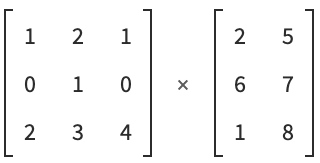

**The number of columns in the first matrix (e.g. the features) should match the number of rows in the second matrix (e.g. the weights)**

## 3. Adding Non-Linearity Between Layers


So far, we've only performed linear transformations (Z = XW). If we stack multiple linear layers, the entire network remains linear. To learn complex, non-linear patterns in data (like classifying images or understanding language), we need to introduce non-linear **activation functions**.

These functions are applied element-wise to the output of the linear layer (Z). A very common activation function is the Rectified Linear Unit (ReLU).

`ReLU(x) = max(0, x)`

Let's consider mapping a 3-dimensional input to a 4-dimensional output (e.g., a hidden layer) and apply ReLU.

*   Input **X**: `(batch_size, 3)`
*   Weights **W**: `(3, 4)`
*   Linear Output **Z = XW**: `(batch_size, 4)`
*   Activated Output **A = ReLU(Z)**: `(batch_size, 4)`




In [35]:
# Define new network dimensions
batch_size = 1 # Keeping batch size 1 for simplicity
input_features_nl = 3
output_features_nl = 4

# Create input tensor
X_nl = torch.randn(batch_size, input_features_nl) # Shape: (1, 3)
print(f"Input X_nl (shape {X_nl.shape}):\n{X_nl}\n{'-'*20}")

# Create weight matrix.
# Using nn.Parameter makes PyTorch track this tensor for gradient calculations during training.
# nn.Linear handles this automatically for its internal weights.
weights_nl = Parameter(torch.randn(input_features_nl, output_features_nl)) # Shape: (3, 4)
print(f"Weights W_nl (shape {weights_nl.shape}):\n{weights_nl}\n{'-'*20}")

# --- Approach 1: Direct matrix multiplication with ReLU ---
# Step 1: Linear transformation Z = XW
Z = torch.matmul(X_nl, weights_nl) # Shape: (1, 3) @ (3, 4) -> (1, 4)
# Step 2: Apply ReLU activation A = ReLU(Z)
output_matmul_relu = torch.relu(Z)

print(f"Linear Output Z (shape {Z.shape}):\n{Z}\n{'-'*20}")
print(f"Activated Output using matmul + ReLU (shape {output_matmul_relu.shape}):\n{output_matmul_relu}\n{'-'*20}")


# --- Approach 2: Using nn.Sequential with nn.Linear and nn.ReLU ---
# nn.Sequential is a container to chain layers/operations together.
layer_relu = nn.Sequential(
    nn.Linear(in_features=input_features_nl,
              out_features=output_features_nl,
              bias=False), # Again, bias=False for direct comparison
    nn.ReLU()
)

# Manually set the weights of the nn.Linear part for comparison
with torch.no_grad():
    # Access the Linear layer within Sequential (it's the first element, index 0)
    # Remember nn.Linear expects weights as (out, in), so transpose weights_nl
    layer_relu[0].weight.copy_(weights_nl.T)

output_sequential_relu = layer_relu(X_nl) # Pass input through the sequence

print(f"Activated Output using nn.Sequential(nn.Linear, nn.ReLU) (shape {output_sequential_relu.shape}):\n{output_sequential_relu}\n{'-'*20}")

"

SyntaxError: unterminated string literal (detected at line 45) (<ipython-input-35-0c6801408874>, line 45)


## Why Non-Linearity? The "Squiggly Function" Idea

*   Linear transformations can only rotate, scale, and shear data. They can only produce linear decision boundaries (straight lines/planes).
*   Non-linear activations like ReLU introduce "bends" or "kinks".
*   By stacking layers with non-linearities (`Linear -> ReLU -> Linear -> ReLU ...`), a neural network can approximate highly complex, non-linear functions or decision boundaries – essentially learning to draw "squiggly" lines/surfaces to separate data points effectively.
*   Think of the spiral dataset example: a [convex set](https://developers.google.com/machine-learning/glossary#convex_set) can't separate the spirals, but a more complex, curved boundary learned by a network with non-linearities can.



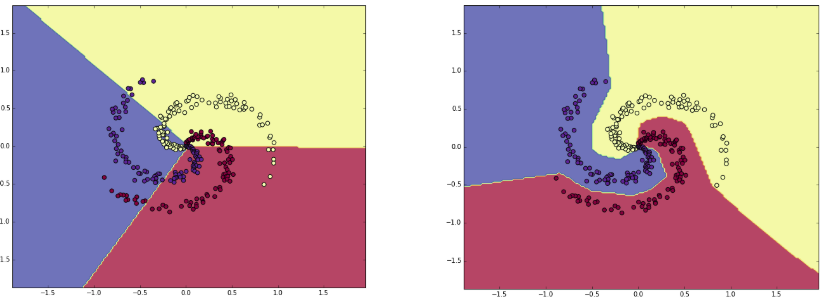

### ReLU Benefits:

*   **Computationally Efficient:** Very fast to compute (`max(0, x)`).
*   **Avoids [Vanishing Gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (for positive inputs):** Unlike [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) or [Tanh](https://paperswithcode.com/method/tanh-activation), the gradient is 1 for positive inputs, which helps avoid [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow#:~:text=The%20term%20arithmetic%20underflow%20(also,central%20processing%20unit%20(CPU).) during training.
*   **Induces Sparsity:** Sets negative inputs to zero, potentially making activations sparse (many zeros), which can ***sometimes*** be beneficial (*no guarantees exist in deep learning!) .

Other activations like Leaky ReLU, ELU, GeLU, Sigmoid, Tanh exist, but ReLU is a very common and effective starting point. Remember that like any other architecture design choice, our chosen activation functions are [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_optimization) that we can tweak and compare using the validation set of our data.




## 4. Practice: Connecting Matrix Multiplication to Network Visualization

Let's use a concrete example to visualize the connection between matrix multiplication shapes and a simple network layer. Imagine mapping 4 input units to 4 output units.

*   Input **X**: `(1, 4)` (1 sample, 4 features)
*   Weights **W**: `(4, 4)` (Connects each of the 4 inputs to each of the 4 outputs; 4*4 = 16 weights total)
*   Output **Z = XW**: `(1, 4)` (1 sample, 4 output features)

We can visualize this as 4 input nodes fully connected to 4 output nodes, with each connection line representing one weight in the `W` matrix.




In [ ]:
# Create the input matrix with specific values
X_practice = torch.tensor([[0.1, 0.2, 0.3, 0.4]], dtype=torch.float32)  # Shape: (1, 4)

# Create the weight matrix with specific values
# Using Parameter signifies these are learnable weights
W_practice = Parameter(torch.tensor([
   [0.11, 0.12, 0.13, 0.14], # Weights connecting Input 1 to Outputs 1, 2, 3, 4
   [0.21, 0.22, 0.23, 0.24], # Weights connecting Input 2 to Outputs 1, 2, 3, 4
   [0.31, 0.32, 0.33, 0.34], # Weights connecting Input 3 to Outputs 1, 2, 3, 4
   [0.41, 0.42, 0.43, 0.44]  # Weights connecting Input 4 to Outputs 1, 2, 3, 4
], dtype=torch.float32))  # Shape: (4, 4)

# Perform matrix multiplication: Z = XW
# Shape check: (1, 4) @ (4, 4) -> (1, 4)
result_practice = torch.matmul(X_practice, W_practice)

# Print results with clear formatting
print("--- Matrix Multiplication Verification ---")
print(f"Input X shape: {X_practice.shape}")
print(f"Input X:\n{X_practice}\n")
print(f"Weight W shape: {W_practice.shape}")
print(f"Weight W:\n{W_practice}\n") # W is a Parameter, print its data
print(f"Output Z = XW shape: {result_practice.shape}")
print(f"Output Z:\n{result_practice.detach()}")  # Use .detach() for printing Parameter results cleanly




### Connecting Shapes to Architecture:

*   The input `X` having shape `(1, 4)` corresponds to 1 data sample with 4 features (or 4 nodes in the input layer/previous hidden layer).
*   The weight matrix `W` having shape `(4, 4)` represents the connections. The first dimension (4) matches the *input features*, and the second dimension (4) determines the *output features*. This signifies 4 input nodes connecting to 4 output nodes.
*   The resulting output `Z` having shape `(1, 4)` corresponds to 1 data sample with 4 resulting features (or 4 nodes in the output/current hidden layer).

Changing the shape of `W` (e.g., to `(4, 10)`) would change the number of output nodes to 10. The inner dimension of `W` *must* match the feature dimension of `X`.




## Key Takeaways

1.  **Matrix Multiplication is Important:** `torch.matmul(X, W)` is the fundamental computation within dense layers of neural networks, transforming input features into output features.
2.  **Shapes Define Architecture:** The dimensions of your input tensor `X (batch, in_features)` and weight matrix `W (in_features, out_features)` dictate the number of input and output neurons and the connections between them. The result `Z` has shape `(batch, out_features)`.
3.  **PyTorch Layers:** `torch.nn.Linear(in_features, out_features)` provides a convenient way to implement these linear transformations, automatically managing weight (and bias) tensors.
4.  **Shape Verification is Important:** Always check tensor shapes (`.shape`) to prevent common runtime errors due to dimension mismatches.
5.  **Non-Linearity is Important:** Linear operations alone are insufficient for complex tasks. Non-linear activation functions (like `torch.nn.ReLU()`) must be applied *after* the matrix multiplication (`Z = XW`) to enable networks to learn complex patterns and create non-linear decision boundaries.
6.  **Building Blocks:** Combining linear layers (`nn.Linear`) with non-linear activations (`nn.ReLU`, etc.), often using `nn.Sequential`, forms the basis for building deep neural networks.




## Further Reading and References


*   **torch.matmul:** [PyTorch Documentation](https://pytorch.org/docs/main/generated/torch.matmul.html)
*   **torch.nn.Linear:** [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
*   **torch.nn.ReLU:** [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
*   **torch.nn.Sequential:** [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
*   **A case study on neural network training (CS231n):** [CS231n Notes](https://cs231n.github.io/neural-networks-case-study/) - Includes interactive examples showing decision boundaries.
*   **Interactive Matrix Multiplication:** [matrixmultiplication.xyz](http://matrixmultiplication.xyz/)
* **Convex Sets**: [Google's Machine Learning Glossary](https://developers.google.com/machine-learning/glossary#convex_set)


